# Data Analysis for Software Engineers

## Practical Assignment 4
## Linear classification

Take into account that some tasks may not have a rigorous and comprehensive solution.

Support your code with comments and illustrations if needed. The more conclusions, derivations and explanations you provide - the better.

In [164]:
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

## (Stochastic) Gradient Descent

Consider the logistic regression method for binary classification. 

In this part, you need to implement the following algorithms for log-loss optimization
* gradient descent (GD) 
* stochastic gradient descent (SGD)

In these three methods a gradient of a loss function $L(w) = \frac{1}{N}\sum_i^N l_i(w)$ is obtained differently:

* In GD the whole training dataset is used: $\nabla_wL(w) = \nabla_w\frac{1}{N}\sum_i l_i(w)$

* In SGD only one random training object $i$ is used for gradient estimation: $\nabla_wL(w) \approx \nabla_w l_i(w)$. So one **epoch** in SGD proceeds as follows:
    * Shuffle training dataset
    * Iterate over dataset objects one by one

## Elastic Net Loss (1 point)

Consider logistic regression with $L_1$ and $L_2$ regularization - elastic net.

$$
L(w, w_0) = \frac{1}{N} \sum_i^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2
$$

Find its gradient and update rules for gradient descent:

Your answer with LaTex:

$$
Consider:
$$

$$
(\|w\|_1)'_w = sign(w)
$$

$$
(\|w\|^2_2)'_w = 2w
$$

$$
-y_i*(w^Tx_i) = -y_i x_{ij}
$$

$$
Result:
$$

$$
\frac{dL}{dw_j} = \frac{1}{N} \sum_{i=1}^N \frac{\exp(-y_i(w^Tx_i + w_0))(-y_ix_{ij})}{1 + \exp(-y_i(w^Tx_i + w_0))}+ \gamma sign(w_j) + 2 \beta w_j
$$
 
$$
\frac{dL}{dw_0} = \frac{1}{N} \sum_{i=1}^N \frac{-y_i\exp(-y_i(w^Tx_i + w_0))}{1 + \exp(-y_i(w^Tx_i + w_0))}
$$

Implement corresponding python function

In [165]:
def get_grad(X, y, coef, intercept, gamma=1., beta=1.):
    # grad_coef is a 1-dim array; grad_intercept is a float number
    N = len(y)
    C = len(coef)
    grad_coef = np.zeros(C)
    grad_intercept = 0
    
    for i in range(N):
        grad_intercept += (-y[i] * np.exp(-y[i]*(np.dot(coef,X[i]) + intercept))) / (1 + np.exp(-y[i]*(np.dot(coef,X[i]) + intercept)))    
    grad_intercept /= N
    
    for i in range(C):
        for j in range(N):
            exponent = np.exp(-y[j]*(coef @ X[j] + intercept))
            grad_coef[i] += ((-y[j]*X[j][i]) * exponent) / (1 + exponent)
        grad_coef[i] = grad_coef[i] / N + gamma*np.sign(coef[i]) + 2*beta*coef[i]
    
    return grad_coef, grad_intercept

In [166]:
# Here you can test your grad computation (comare your exact computation with numerical approximation)

def loss(X, y, coef, intercept, gamma=1., beta=1.):
    return np.log(1+np.exp(-y*(X @ coef+ intercept))).mean() + gamma * np.linalg.norm(coef, ord=1) + beta * (np.linalg.norm(coef, ord=2) ** 2)

def get_grad_numerical(X, y, coef, intercept, gamma=1., beta=1., eps=0.000001):
    mean_grad_coef = []
    for i, _ in enumerate(coef):
        coef_ = coef.copy()
        coef_[i]+=eps
        mean_grad_coef.append((loss(X, y, coef_, intercept, gamma=1., beta=1.) - loss(X, y, coef, intercept, gamma=1., beta=1.))/eps)
        
    intercept_ = intercept+eps
    mean_grad_intercept = (loss(X, y, coef, intercept_, gamma=1., beta=1.) - loss(X, y, coef, intercept, gamma=1., beta=1.))/eps
    
    return np.array(mean_grad_coef), mean_grad_intercept

np.random.seed(1928)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
coef, intercept = np.random.normal(size=5), np.random.normal()

grad_coef, grad_intercept = get_grad(X, y, coef, intercept)
grad_coef_numerical, grad_intercept_numerical = get_grad_numerical(X, y, coef, intercept)

assert(np.allclose(grad_coef,
                   grad_coef_numerical,
                   rtol=1e-2) & \
       np.allclose(grad_intercept,
                   grad_intercept_numerical, 
                   rtol=1e-2)
)

# Algorithm Implementation (3 points)

Some hints:
* Small random numbers from $[−1/2d,1/2d]$ should be chosen for weight initialization. ($d$ - feature space dimension)
* The efficient step size for GD is approximately $0.01 − 1$.
* Step size should be constant for GD and decreasing for SGD, for example, $\alpha/\text{epoch_number}$ where $\alpha$ is some constant
*  use [`sklearn.utils.shuffle`](http://scikit-learn.org/stable/modules/generated/sklearn.utils.shuffle.html) to shuffle `X` and `y` in a consistent way
* Stopping criteria: for GD use $|L_{old} − L_{new}| < tol$, for SGD simply do a particular number of iterations.
* For code efficiency use numpy vectors to compute gradients

In [167]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [168]:
def random_vector(d):
    return (np.random.random(d) - 0.5) * d

def random_number():
    return np.random.random() - 0.5;

In [221]:
# Class for simple gradient descent
class MyVanillaGD(BaseEstimator, ClassifierMixin):
    def __init__(self, step=0.2, beta=0.01, gamma=0.01, tol=1e-4, max_epoch=1000, random_state=123):
        self.beta = beta        
        self.gamma = gamma
        self.tol = tol
        self.max_epoch = max_epoch
        self.random_state = random_state

        # my fields
        np.random.seed(random_state)
        self.step = step
        
        self.coef = np.zeros(1)
        self.intercept = 0.
        
        
    def fit(self, X, y):
        # randoming coefs
        self.coef = random_vector(X.shape[1])
        self.intercept = random_number()
        
        # setting loss variables
        L_prev = loss(X, y, self.coef, self.intercept, self.gamma, self.beta)
        L_cur = 0
        loss_process = [L_prev, ]
        
        # using max_epoch as another stopping criteria
        for i in range(self.max_epoch):           
            # update for L_cur, coef and intercept
            
            # debug
            #print('i = ', i)
            #print ('X = ', X)
            #print('y = ', y)
            #print('coef = ', self.coef)
            #print('intercept = ', self.intercept)
            #print('gamma = ', self.gamma)
            #print('beta = ', self.beta, '\n\n')
            
            grad_coef, grad_intercept = get_grad(X, y, self.coef, self.intercept, self.gamma, self.beta)
            
            # moving on constant step (as written on top - for GD constant step)
            self.coef -= np.sign(grad_coef) * self.step
            self.intercept -= np.sign(grad_intercept) * self.step
            
            # and counting new loss
            L_cur = loss(X, y, self.coef, self.intercept, self.gamma, self.beta)
            loss_process.append(L_cur)
            
            # breaking if tolerance rule not passed
            if (np.abs(L_prev - L_cur) < self.tol):
                break
                
            # reassigning L_prev and L_cur
            L_prev = L_cur
        
        return loss_process
    
    def predict(self, X):
        v = (self.predict_proba(X) > 0.5).astype(int)
        v[v == 0] = -1
        
        return v
        
    def predict_proba(self, X):
        return 1 / (1 + np.exp(- X @ self.coef - self.intercept))

        
# Class for SGD
class MySGD(BaseEstimator, ClassifierMixin):
    def __init__(self, step=0.01, beta=1.0, gamma=1.0, max_epoch=1000, random_state=123):
        self.beta = beta        
        self.gamma = gamma
        self.max_epoch = max_epoch
        self.random_state = random_state

        np.random.seed(random_state)
        self.step = step
        
        self.coef = []
        self.intercept = 0
    
    def fit(self, X, y):
        # randoming coefs
        self.coef = random_vector(X.shape[1])
        self.intercept = random_number()
        
        # setting loss array
        loss_process = [loss(X, y, self.coef, self.intercept, self.gamma, self.beta), ]
        
        # using max_epoch as another stopping criteria
        for i in range(self.max_epoch):
            for j in range(y.shape[0]):
                # update for gradients
                grad_coef, grad_intercept = get_grad(np.array([X[j],]), np.array([y[j],]), self.coef, self.intercept, self.gamma, self.beta)

                # moving on decreasing step
                self.coef -= grad_coef * self.step
                self.intercept -= grad_intercept * self.step
                
            loss_process.append(loss(X, y, self.coef, self.intercept, self.gamma, self.beta))
        
        return loss_process
    
    def predict(self, X):
        v = (self.predict_proba(X) > 0.5).astype(int)
        v[v == 0] = -1
        
        return v
        
    def predict_proba(self, X):
        return 1 / (1 + np.exp(- X @ self.coef - self.intercept))

# Checking on simple datasets (1 point)

Let's check your models on a toy dataset. Don’t forget to standardize the data and then add a constant feature to it. Use the same random state for GD and SGD

Here you should demonstrate the following plots:
* data points and decision boundary for each method,
* $L(w)$ as a function of epoch number (for both GD and SGD).

In [210]:
from sklearn.datasets import make_classification

RND_SEED = 123

In [211]:
def get_toy_dataset():
    return make_classification(n_samples=1000, n_features=2, class_sep=0.5, 
                               n_clusters_per_class=1, n_redundant=0, 
                               shift=4, scale=2, random_state=RND_SEED)

def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 500),
                         np.linspace(X2min, X2max, 500))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

0.98


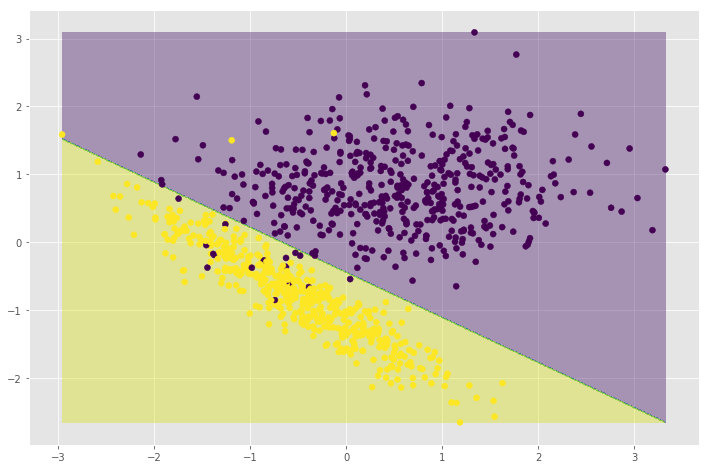

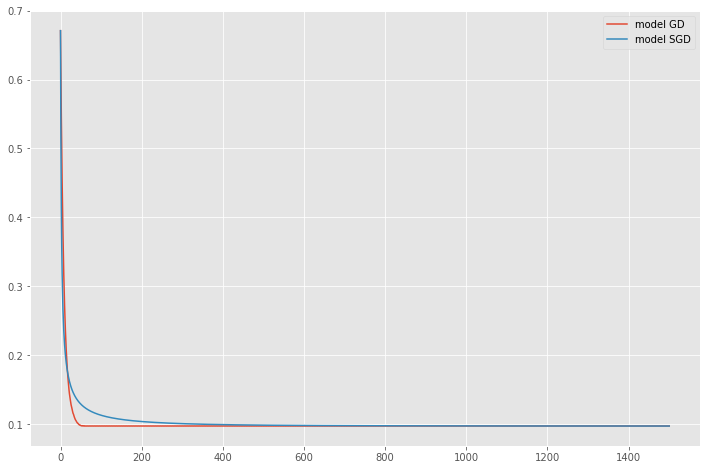

In [259]:
# using stardartization from sklearn
X, y = get_toy_dataset()
y[y == 0] = -1
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

gd = MyVanillaGD(step = 0.1, beta = 0., gamma = 0., tol = 1e-8, max_epoch = 1500, random_state = RND_SEED)
lossGD = gd.fit(X, y)
predict = gd.predict(X)
print(accuracy_score(y, predict))
plot_decision_boundary(gd, X, y)

'''
    sgd = MySGD(step = 1e-3, beta = 0., gamma = 0., max_epoch = 1500, random_state = RND_SEED)
    lossSGD = sgd.fit(X, y)
    predict = sgd.predict(X)
    print(accuracy_score(y, predict))
    plot_decision_boundary(sgd, X, y)
'''

# drawing loss functions
fig = plt.figure()
plt.plot(lossGD, label='model GD')
plt.plot(lossSGD, label='model SGD')
plt.legend()

# Regulatization (2 points)

#### Task 1

* Load the dataset from 'audit' folder. Fit a logistic regression classifier on the training samples. Use GD with different regularizations (without one, only L1, only L2, L1 and L2), use the same random state for all runs. Don’t forget to standardize the data (for example use StandardScaler from sklearn.preprocessing) and then add a constant feature to it.
* split data on train and test, using train_test_split from sklearn with test_size = 0.3 (don't forget set random_state)
* Plot loss on test data_set wrt to epoch number

In [213]:
data = pd.read_csv("audit_risk.csv")
data.head()

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
0,3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5.0,...,0.4,0,0.2,0.0,2.4,8.574,0.4,0.5,1.7148,1
1,3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5.0,...,0.4,0,0.2,0.0,2.0,2.554,0.4,0.5,0.5108,0
2,3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5.0,...,0.4,0,0.2,0.0,2.0,1.548,0.4,0.5,0.3096,0
3,3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6.0,...,0.4,0,0.2,0.0,4.4,17.530,0.4,0.5,3.5060,1
4,3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5.0,...,0.4,0,0.2,0.0,2.0,1.416,0.4,0.5,0.2832,0


In [214]:
y = data["Risk"]
y = np.array(y.replace(0, -1))

Xdata = data.drop(["Risk"], axis=1)
scaler = StandardScaler() 
scaler.fit(Xdata)
X = scaler.transform(Xdata)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RND_SEED)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys


In [222]:
no_reg_model = MyVanillaGD(beta = 0., gamma = 0.)
no_reg = no_reg_model.fit(X_train, y_train)
pred = no_reg_model.predict(X_test)
print(accuracy_score(y_test, pred))

0.9742489270386266


In [224]:
L1_model = MyVanillaGD(beta = 0., gamma = 0.03)
L1 = L1_model.fit(X_train, y_train)
pred = L1_model.predict(X_test)
print(accuracy_score(y_test, pred))

0.9399141630901288


In [225]:
L2_model = MyVanillaGD(beta = 0.03, gamma = 0.)
L2 = L2_model.fit(X_train, y_train)
pred = L2_model.predict(X_test)
print(accuracy_score(y_test, pred))

0.9527896995708155


In [226]:
L1L2_model = MyVanillaGD(beta = 0.03, gamma = 0.03)
L1L2 = L1L2_model.fit(X_train, y_train)
pred = L1L2_model.predict(X_test)
print(accuracy_score(y_test, pred))

0.9227467811158798


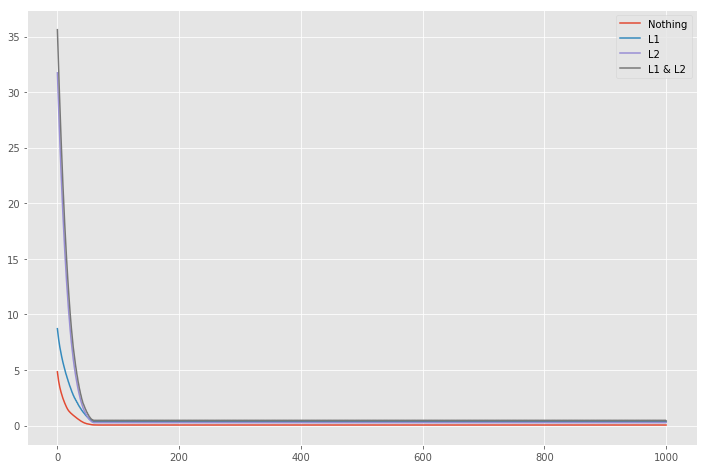

In [227]:
fig = plt.figure()
plt.plot(no_reg, label='Nothing')
plt.plot(L1, label='L1')
plt.plot(L2, label='L2')
plt.plot(L1L2, label='L1 & L2')
plt.legend()

In [263]:
# beta = 0, gamma = 0 - is the best result
test_model = MyVanillaGD(beta = 0.03, gamma = 0.03, step = 0.05, tol = 1e-8, max_epoch = 1000, random_state = RND_SEED)
fit = test_model.fit(X_train, y_train)

# model - your logreg, X_test, y_test - your test data
from sklearn.metrics import roc_auc_score
y_score = test_model.predict_proba(X_test)
assert(roc_auc_score(y_test, y_score) > 0.99)

KeyboardInterrupt: 

#### Task 2

* Use the resulting weights vector of GD with L1 regularization to determine two most important features. Fit the logistic classifier only on these two features (+ the constant one) and visualize the decision boundary. Does L1 regularization help you to chose important features?

In [233]:
gd = MyVanillaGD(beta = 0., gamma = 0.03, step = 0.2, tol = 1e-8, max_epoch = 1000, random_state = RND_SEED)

gd.fit(X_train, y_train)

coef = gd.coef
intercept = gd.intercept

acoef = np.abs(coef)

[ 5 12  9  7 18 19 17  1 11 10 23  0  8  2 20  4 16 14 24 25 22 21  6  3
 15 13]


In [265]:
a = acoef.argsort()
for i in range(len(a)):
    print(Xdata.columns[a[i]], ': ', acoef[i])

Sector_score :  0.0007679632359846589
LOCATION_ID :  0.0028783616702346415
PARA_A :  0.004944526952085859
Score_A :  0.005573203206443111
Risk_A :  0.020335719887797643
PARA_B :  0.027517264518517603
Score_B :  0.03825434016519075
Risk_B :  0.03962270870986856
TOTAL :  0.04470760801492041
numbers :  0.07737158007739381
Score_B.1 :  0.08661127761715398
Risk_C :  0.09180117445560004
Money_Value :  0.09577056140661566
Score_MV :  0.09813779266928474
Risk_D :  0.10557507766565344
District_Loss :  0.1061932144246368
PROB :  0.14478499179100313
RiSk_E :  0.14915063859121747
History :  0.18352794682575746
Prob :  0.1969317601826357
Risk_F :  0.23583844637651297
Score :  0.6852266460225269
Inherent_Risk :  0.8998691580000133
CONTROL_RISK :  0.9341839961551721
Detection_Risk :  0.9878805490329241
Audit_Risk :  1.3516253118487704


#### Task 3

* Provide visual demonstration, that your regularization works. For each feature plot its weight wrt to regularization coefficients

 * $\beta = 0$, $\gamma \in [10^{-4}, 10^4]$
 * $\beta \in [10^{-4}, 10^4]$, $\gamma = 0$
 * $\beta \in [10^{-4}, 10^4]$, $\gamma = 0.2 \cdot \beta$

Your plots should look similar to
<img src="example.png" />

In [264]:
reg1 = np.linspace(0.0001, 0.5, 30)
reg2 = np.linspace(0.01, 1, 10)
reg3 = np.linspace(1, 100, 10)
reg4 = np.linspace(100, 1000, 10)
reg5 = np.linspace(1000, 10000, 10)
reg_a = np.concatenate((reg1, reg2, reg3), axis=0)
reg_s = np.arange(1, 1000, )
reg_s = reg_s ** 2
reg_s = reg_s * 0.001

In [275]:
def regulatization(Xdata, X, y, gamma, beta, flag):
    coefs = []
    for i in range(len(beta)):
        model = MyVanillaGD(beta = beta[i], gamma = gamma[i], tol = 1e-3)
        model.fit(X, y)
        coef = model.coef
        coefs.append(coef)
    
    # print(coefs)
    fig = plt.figure()
    for j in range(Xdata.columns.shape[0]):
        plt.plot(beta if flag else gamma, coefs[:, j])
    plt.xlabel("Regularisation coef")
    plt.ylabel("Weights")

In [276]:
gamma = reg1
beta = np.zeros_like(gamma)
regulatization(Xdata, X, y, gamma, beta, False)

TypeError: list indices must be integers or slices, not tuple

<Figure size 864x576 with 0 Axes>

# Real Dataset (3 points)

In this part of the task you will work with the problem of diabetes diagnostics. Load the diabetes dataset using pickle.load.

This dataset has the following features:
1. Number of pregnancies
2. Plasma glucose concentration after 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure
4. Triceps skin fold thickness
5. 2-Hour serum insulin
6. Body mass index
7. Diabetes pedigree function
8. Age

Class label is equal to 1 if a person has a diabetes and to -1 otherwise.

#### Task 1

Train the logistic regression classifier on this dataset. Use SGD without regularization. Don’t
forget to standardize the data and then add a constant feature to it.

In [ ]:
with open('diabetes.pkl', 'rb') as fin:     
    d = pickle.load(fin,encoding='latin')

In [ ]:
# model - your logreg, X_test, y_test - your test data
from sklearn.metrics import roc_auc_score
y_score = model.predict_proba(X_test)[:,1]
assert(roc_auc_score(y_test, y_score) > 0.793)

#### Task 2

In diagnostic problems, false positive and false negative errors have different costs. 

Let’s say, if we make a false negative error (don’t detect a condition when it is present), then the patient doesn’t have a necessary treatment and, if we make false positive error (detect a condition when it isn’t present), then the patient simply need to be tested more. 

Therefore, the cost of false negative error is higher, and we care much more about this type of error. Compute a confusion matrix for a fitted classifier. 

How many errors of each type have you got? Compute a false positive and false negative rates for this classifier. Why are they so different?

Useful functions: `sklearn.metrics.confusion_matrix`.

#### Task 3

To change the proportion of errors of different types you can change a threshold a at the prediction
rule $y = \sigma(w^\top x + w_0) > a$, where $a \in [0, 1]$.

Show the ROC-curve of the fitted classifier and a point on it, which corresponds to $a = 0.5$ (the one you
computed at the previous step). 

Using ROC-curve choose a so that false negative rate is less than $20%$ while a false positive rate is still small. What accuracy and false positive rate does the final algorithm have?

Useful functions: `sklearn.metrics.roc_curve`.